# **Imbalanced metric interpolation testing**

The aim of this notebook is to the test the behavior of the balanced and imbalanced clustering
metrics over a range of balanced/imbalanced scenarios, as opposed to fixed scenarios with 
fixed cluster/class sizes. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, \
    homogeneity_score, completeness_score, v_measure_score
from sklearn.cluster import KMeans

from balanced_clustering import balanced_adjusted_rand_index, \
    balanced_adjusted_mutual_info, balanced_completeness, \
    balanced_homogeneity, balanced_v_measure 

We can start by defining some important functions that will let us do the interpolation and testing.

In [2]:
# Define function to return all the relevant metrics - both balanced
# and imbalanced
def return_metrics(class_arr, cluster_arr):
    # Determine the imbalanced (base) metric scores 
    ari_imbalanced = adjusted_rand_score(class_arr, cluster_arr)
    ami_imbalanced = adjusted_mutual_info_score(class_arr, cluster_arr)
    homog_imbalanced = homogeneity_score(class_arr, cluster_arr)
    complete_imbalanced = completeness_score(class_arr, cluster_arr)
    v_measure_imbalanced = v_measure_score(class_arr, cluster_arr)

    # Determine the balanced metrics from `imbalanced-clustering`
    ari_balanced = balanced_adjusted_rand_index(class_arr, cluster_arr)
    ami_balanced = balanced_adjusted_mutual_info(class_arr, cluster_arr)
    homog_balanced = balanced_homogeneity(class_arr, cluster_arr)
    complete_balanced = balanced_completeness(class_arr, cluster_arr)
    v_measure_balanced = balanced_v_measure(class_arr, cluster_arr)
    
    # Return paired balanced imbalance scores
    return (ari_imbalanced, ari_balanced), (ami_imbalanced, ami_balanced), \
        (homog_imbalanced, homog_balanced), (complete_imbalanced, complete_balanced), \
        (v_measure_imbalanced, v_measure_balanced)

We'll begin with **Experiment 1**, where we have a scenario where we have 3 ground truth classes,
but the clustering result occurs with k = 2 in a k-means setting and effectively merges a smaller
cluster together with a larger one.

We know in this setting that the balanced clustering metrics will penalize the scores more severely
than the imbalanced metrics:

Class scatterplot:


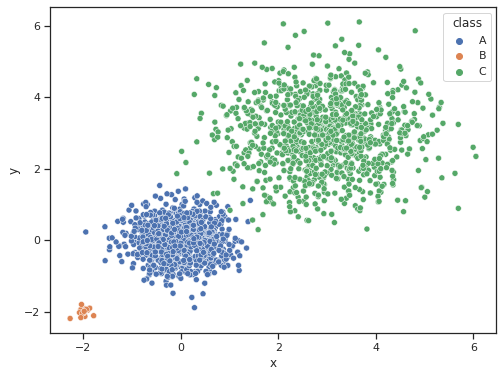

K-means classification scatterplot:


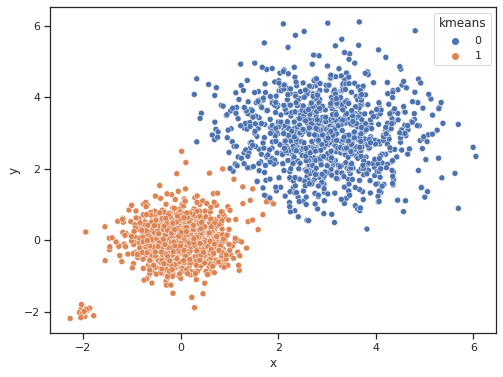

ARI imbalanced: 0.945 ARI balanced: 0.5503
AMI imbalanced: 0.9035 AMI balanced: 0.6959
Homogeneity imbalanced: 0.8737 Homogeneity balanced: 0.5483
Completeness imbalanced: 0.9356 Completeness balanced : 0.9528
V-measure imbalanced: 0.9036 V-measure balanced: 0.696


<Figure size 576x432 with 0 Axes>

In [10]:
# Sample three classes from separated gaussian distributions with varying
# standard deviations and class size 
c_1 = np.random.default_rng(seed = 0).normal(loc = 0, scale = 0.5, size = (1000, 2))
c_2 = np.random.default_rng(seed = 1).normal(loc = -2, scale = 0.1, size = (20, 2))
c_3 = np.random.default_rng(seed = 2).normal(loc = 3, scale = 1, size = (1000, 2))

# Plot the given results for each class using seaborn
# Ensure to clear plot afterwards 
cluster_df = pd.DataFrame({
    "x" : np.concatenate((c_1[:, 0], c_2[:, 0], c_3[:, 0])),
    "y" : np.concatenate((c_1[:, 1], c_2[:, 1], c_3[:, 1])),
    "class": np.concatenate(
        (
            np.repeat("A", len(c_1)),
            np.repeat("B", len(c_2)),
            np.repeat("C", len(c_3))
        )
    )
})
print("Class scatterplot:")
sns.set(rc = {'figure.figsize':(8, 6)})
sns.set_style("ticks")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "class",
    data = cluster_df
)
plt.show()
plt.clf()

# Perform k-means clustering with k = 2, and plot the results  
cluster_arr = np.array(cluster_df.iloc[:, 0:2])
kmeans_res = KMeans(n_clusters = 2, random_state = 42).fit_predict(X = cluster_arr)

cluster_df["kmeans"] = kmeans_res # Add k-means to cluster df 
print("K-means classification scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "kmeans",
    data = cluster_df
)
plt.show()
plt.clf()

# Return and print balanced and imbalanced comparisons 
aris, amis, homogs, completes, v_measures = return_metrics(
    class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
)
print(
    "ARI imbalanced: " + str(round(aris[0], 4)) + " " + 
    "ARI balanced: " + str(round(aris[1], 4))
)
print(
    "AMI imbalanced: " + str(round(amis[0], 4)) + " " +
    "AMI balanced: " + str(round(amis[1], 4))
)
print(
    "Homogeneity imbalanced: " + str(round(homogs[0], 4)) + " " +
    "Homogeneity balanced: " + str(round(homogs[1], 4))
)
print(
    "Completeness imbalanced: " + str(round(completes[0], 4)) + " " +
    "Completeness balanced : " + str(round(completes[1], 4))
)
print(
    "V-measure imbalanced: " + str(round(v_measures[0], 4)) + " " +
    "V-measure balanced: " + str(round(v_measures[1], 4))
)

Now, instead of a fixed size, let's interpolate over a range of values for the number of samples in the smaller class. This will start from the size of the smallest class initially (20), to the same number of samples as the larger classes (1000). We'll check the behaviour of the 5 balanced and imbalanced metrics along this continuum. We expect that the imbalanced metrics will asymptotically approach the balanced metrics as the class sizes become more even.

In [26]:
# Define a range of values for the smaller cluster
small_clus_range = np.arange(20, 1010, 10)

# Iterate over range and get the resulting balanced and imbalanced values 
# for the clustering metrics
ari_imba = []
ami_imba = []
homog_imba = []
complete_imba = []
v_measure_imba = []
ari_bal = []
ami_bal = []
homog_bal = []
complete_bal = []
v_measure_bal = []

for clus_size in small_clus_range:
    # Sample three classes from separated gaussian distributions with varying
    # standard deviations and class size 
    c_1 = np.random.default_rng(seed = 0).normal(loc = 0, scale = 0.5, size = (1000, 2))
    c_2 = np.random.default_rng(seed = 1).normal(loc = -2, scale = 0.1, size = (clus_size, 2))
    c_3 = np.random.default_rng(seed = 2).normal(loc = 3, scale = 1, size = (1000, 2))

    # Create dataframe of the results
    cluster_df = pd.DataFrame({
        "x" : np.concatenate((c_1[:, 0], c_2[:, 0], c_3[:, 0])),
        "y" : np.concatenate((c_1[:, 1], c_2[:, 1], c_3[:, 1])),
        "class": np.concatenate(
            (
                np.repeat("A", len(c_1)),
                np.repeat("B", len(c_2)),
                np.repeat("C", len(c_3))
            )
        )
    })

    # Perform k-means clustering with k = 2 and append relevant information
    cluster_arr = np.array(cluster_df.iloc[:, 0:2])
    kmeans_res = KMeans(n_clusters = 2, random_state = 42).fit_predict(X = cluster_arr)
    cluster_df["kmeans"] = kmeans_res # Add k-means to cluster df 

    # Return and append balanced and imbalanced comparisons 
    aris, amis, homogs, completes, v_measures = return_metrics(
        class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
    )
    ari_imba.append(aris[0])
    ami_imba.append(amis[0])
    homog_imba.append(homogs[0])
    complete_imba.append(completes[0])
    v_measure_imba.append(v_measures[0])
    ari_bal.append(aris[1])
    ami_bal.append(amis[1])
    homog_bal.append(homogs[1])
    complete_bal.append(completes[1])
    v_measure_bal.append(v_measures[1])

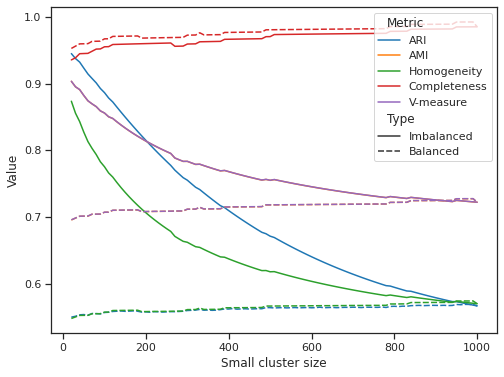

<Figure size 576x432 with 0 Axes>

In [29]:
# Plot and compare the results of the balanced and imbalanced metrics 
imba_df = pd.DataFrame({
    "ARI": ari_imba,
    "AMI": ami_imba,
    "Homogeneity": homog_imba,
    "Completeness": complete_imba,
    "V-measure": v_measure_imba
})
imba_df["Type"] = "Imbalanced"
imba_df["Small cluster size"] = small_clus_range

bal_df = pd.DataFrame({
    "ARI": ari_bal,
    "AMI": ami_bal,
    "Homogeneity": homog_bal,
    "Completeness": complete_bal,
    "V-measure": v_measure_bal
})
bal_df["Type"] = "Balanced"
bal_df["Small cluster size"] = small_clus_range

imba_bal_df = pd.concat([imba_df, bal_df], axis = 0)
imba_bal_df_melt = pd.melt(
    imba_bal_df,
    id_vars = ["Type", "Small cluster size"]
)
imba_bal_df_melt.columns = ["Type", "Small cluster size", "Metric", "Value"]
sns.lineplot(
    data = imba_bal_df_melt,
    x = "Small cluster size", 
    y = "Value",
    hue = "Metric",
    style = "Type",
    palette = "tab10"
)
plt.show()
plt.clf()


As we can see from this figure, the behavior of the imbalanced metrics asymptotically approaches that of the balanced metrics as the class imbalance approaches 0 (all classes have the same cluster number). In settings where the clusters are perfectly separated, the metrics would be equivalent regardless. **Note that the AMI lines are covered up perfectly by the V-measure lines - both are entropy-based metrics with a similar form**. 

The metric that is the exception is the completeness, which seems to result in approximately the same value for both the imbalanced and balanced metrics - a high value which does not change with the size of the smaller class. This is because completneess measures if all members of a given class are members of the same cluster. In this case, as the smaller class is being collapsed into a single cluster, this will still hold - and it will hold regardless of the size scaling of this smaller cluster. Therefore, we expect the completeness to be high regardless and the balanced completeness will reweigh the classes, but it will not change the score as condition holds perfectly to begin with.

This result indicates that the interpolation is behaving as expected for this case.

For the next interpolation test, let's consider the following scenario:

3 classes that are mixed together, 2 of them smaller than the majority class. We'll use the correct k in this case (k = 3) for the number of classes. In this setting, the larger class will be once again driving the base metrics and resulting in poor scores, but since the smaller classes are clustered more appropriately, we'd like the balanced scores to be higher after accounting for this fact. Let's have a look at this:

Class scatterplot:


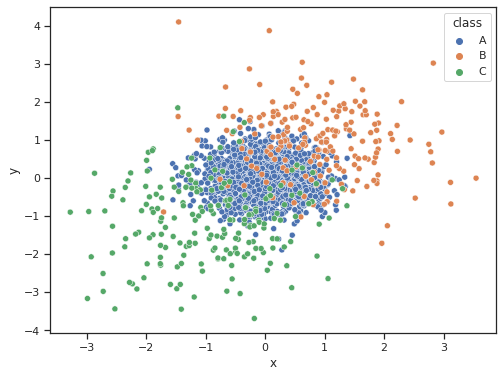

K-means classification scatterplot:


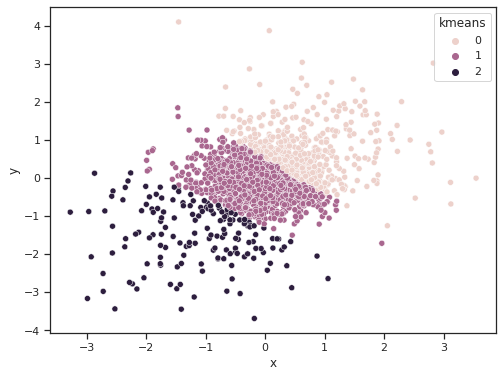

ARI imbalanced: 0.3551 ARI balanced: 0.436
AMI imbalanced: 0.3125 AMI balanced: 0.4328
Homogeneity imbalanced: 0.3557 Homogeneity balanced: 0.4278
Completeness imbalanced: 0.2802 Completeness balanced : 0.4391
V-measure imbalanced: 0.3135 V-measure balanced: 0.4334


<Figure size 576x432 with 0 Axes>

In [30]:
# Sample three classes, not that well separated, from gaussian distributions with 
# varying standard deviations and class size, such that the larger class is in 
# the middle and smaller classes on the edges  
c_1 = np.random.default_rng(seed = 0).normal(loc = 0, scale = 0.5, size = (1500, 2))
c_2 = np.random.default_rng(seed = 1).normal(loc = 1, scale = 1, size = (200, 2))
c_3 = np.random.default_rng(seed = 2).normal(loc = -1, scale = 1, size = (200, 2))

# Plot the given results for each class using seaborn
# Ensure to clear plot afterwards 
cluster_df = pd.DataFrame({
    "x" : np.concatenate((c_1[:, 0], c_2[:, 0], c_3[:, 0])),
    "y" : np.concatenate((c_1[:, 1], c_2[:, 1], c_3[:, 1])),
    "class": np.concatenate(
        (
            np.repeat("A", len(c_1)),
            np.repeat("B", len(c_2)),
            np.repeat("C", len(c_3))
        )
    )
})
print("Class scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "class",
    data = cluster_df
)
plt.show()
plt.clf()

# Perform k-means clustering with k = 2, and plot the results  
cluster_arr = np.array(cluster_df.iloc[:, 0:2])
kmeans_res = KMeans(n_clusters = 3, random_state = 42).fit_predict(X = cluster_arr)

cluster_df["kmeans"] = kmeans_res # Add k-means to cluster df 
print("K-means classification scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "kmeans",
    data = cluster_df
)
plt.show()
plt.clf()

# Return and print balanced and imbalanced comparisons 
aris, amis, homogs, completes, v_measures = return_metrics(
    class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
)
print(
    "ARI imbalanced: " + str(round(aris[0], 4)) + " " + 
    "ARI balanced: " + str(round(aris[1], 4))
)
print(
    "AMI imbalanced: " + str(round(amis[0], 4)) + " " +
    "AMI balanced: " + str(round(amis[1], 4))
)
print(
    "Homogeneity imbalanced: " + str(round(homogs[0], 4)) + " " +
    "Homogeneity balanced: " + str(round(homogs[1], 4))
)
print(
    "Completeness imbalanced: " + str(round(completes[0], 4)) + " " +
    "Completeness balanced : " + str(round(completes[1], 4))
)
print(
    "V-measure imbalanced: " + str(round(v_measures[0], 4)) + " " +
    "V-measure balanced: " + str(round(v_measures[1], 4))
)

Once again we'll vary the size of the classes until things are even, but this time, we'll decrease the size of the larger class until it is the same as the sizes of the two smaller classes. Lets check the behaviour of the 5 balanced and imbalanced metrics along this continuum.  

In [31]:
# Define a range of values for the larger cluster
large_clus_range = np.flip(np.arange(200, 1510, 10))

# Iterate over range and get the resulting balanced and imbalanced values 
# for the clustering metrics
ari_imba = []
ami_imba = []
homog_imba = []
complete_imba = []
v_measure_imba = []
ari_bal = []
ami_bal = []
homog_bal = []
complete_bal = []
v_measure_bal = []

for clus_size in large_clus_range:
    # Sample three classes, not that well separated, from gaussian distributions with 
    # varying standard deviations and class size, such that the larger class is in 
    # the middle and smaller classes on the edges  
    c_1 = np.random.default_rng(seed = 0).normal(loc = 0, scale = 0.5, size = (clus_size, 2))
    c_2 = np.random.default_rng(seed = 1).normal(loc = 1, scale = 1, size = (200, 2))
    c_3 = np.random.default_rng(seed = 2).normal(loc = -1, scale = 1, size = (200, 2))

    # Create dataframe of the results
    cluster_df = pd.DataFrame({
        "x" : np.concatenate((c_1[:, 0], c_2[:, 0], c_3[:, 0])),
        "y" : np.concatenate((c_1[:, 1], c_2[:, 1], c_3[:, 1])),
        "class": np.concatenate(
            (
                np.repeat("A", len(c_1)),
                np.repeat("B", len(c_2)),
                np.repeat("C", len(c_3))
            )
        )
    })

    # Perform k-means clustering with k = 3 and append relevant information
    cluster_arr = np.array(cluster_df.iloc[:, 0:2])
    kmeans_res = KMeans(n_clusters = 3, random_state = 42).fit_predict(X = cluster_arr)
    cluster_df["kmeans"] = kmeans_res # Add k-means to cluster df 

    # Return and append balanced and imbalanced comparisons 
    aris, amis, homogs, completes, v_measures = return_metrics(
        class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
    )
    ari_imba.append(aris[0])
    ami_imba.append(amis[0])
    homog_imba.append(homogs[0])
    complete_imba.append(completes[0])
    v_measure_imba.append(v_measures[0])
    ari_bal.append(aris[1])
    ami_bal.append(amis[1])
    homog_bal.append(homogs[1])
    complete_bal.append(completes[1])
    v_measure_bal.append(v_measures[1])

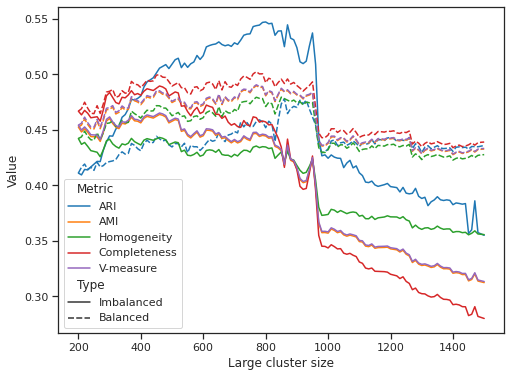

<Figure size 576x432 with 0 Axes>

In [32]:
# Plot and compare the results of the balanced and imbalanced metrics 
imba_df = pd.DataFrame({
    "ARI": ari_imba,
    "AMI": ami_imba,
    "Homogeneity": homog_imba,
    "Completeness": complete_imba,
    "V-measure": v_measure_imba
})
imba_df["Type"] = "Imbalanced"
imba_df["Large cluster size"] = large_clus_range

bal_df = pd.DataFrame({
    "ARI": ari_bal,
    "AMI": ami_bal,
    "Homogeneity": homog_bal,
    "Completeness": complete_bal,
    "V-measure": v_measure_bal
})
bal_df["Type"] = "Balanced"
bal_df["Large cluster size"] = large_clus_range

imba_bal_df = pd.concat([imba_df, bal_df], axis = 0)
imba_bal_df_melt = pd.melt(
    imba_bal_df,
    id_vars = ["Type", "Large cluster size"]
)
imba_bal_df_melt.columns = ["Type", "Large cluster size", "Metric", "Value"]
sns.lineplot(
    data = imba_bal_df_melt,
    x = "Large cluster size", 
    y = "Value",
    hue = "Metric",
    style = "Type",
    palette = "tab10"
)
plt.show()
plt.clf()


In this case, we can observe some interesting behavior as the size for the middle class increases from 200 (balanced case, same as two other classes) to 2000 (most imbalanced case). 

To start, the results for the balanced and imbalanced metrics is very similar, and this is expected because the class sizes are the same in this scenario (no imbalance present). As the middle class gets larger, we see an increase in the values for the imbalanced ARI, while the rest of the metrics fluctuate with no specific pattern. This is likely because of class imbalance - more samples from the middle class are being correctly clustered, so the score for the imbalanced ARI is being inflated. The balanced ARI however, stays stable. Other metrics that are entropy based (AMI, V-measure and its different parts) seem more robust to fluctuations at this point.

When the large cluster size reaches around 800, things start to change, as the imbalanced metrics dip in their score - with a very significant dip at ~950 and a steady decrease afterwards. This is happening because the size of the middle class is increasing, but now due to collisions with the smaller classes on the edges, it's being misclustered at a higher rate. In the balanced setting, this is acceptable, because most of the smaller classes are still being clustered correctly, and this is reflected in the stability of the balanced metrics after a small dip at ~950. 

This case indicates that the balanced and imbalanced metrics have complex behavior in cases where the classes are not perfectly separated and clustered, and that the balanced metrics interpolate smoothly across varying levels of imbalance and the nuances that may occur in specific clustering scenarios.